In [3]:
###test to see if we can implement basic method by Countinglab

import numpy as np
import pandas as pd
import os
import csv
from collections import defaultdict
import statsmodels.formula.api as sm
from datetime import datetime
import matplotlib.pyplot as plt

path = os.getcwd()

In [4]:
#Read in the modified dataframe
df = pd.read_csv(path + '/GEFCOM/mod_data.csv')

#create a variable for season
def season(row):
    if row['month'] < 3:
        val = 'winter'
    elif row['month'] < 6:
        val = 'spring'
    elif row['month'] < 9:
        val = 'summer'
    elif row['month'] < 12:
        val = 'fall'
    else:
        val = 'winter'   
    return val

df['season'] = df.apply(season, axis=1)

#create interaction terms between weather and total day
for i in range(1, 12):
    t2 = 'w{}2'.format(i)
    td = 'w{}d'.format(i)
    t2d = 'w{}2d'.format(i)
    df[t2] = df['w{}'.format(i)]**2
    df[td] = df['w{}'.format(i)] * df['totDay']
    df[t2d] = df['w{}'.format(i)]**2 * df['totDay']

In [5]:
dataframes = defaultdict(dict)
###split up into 3840 dataframes
#By season
for seas, df_season in df.groupby('season'):
    #By Weekday
    for weekday, df_weekday in  df_season.groupby('weekday'):
        dataframes[seas][weekday] = defaultdict(dict)
        #by hour
        for zone, df_zone in df_weekday.groupby('zone'):
            for hour, df_hour in df_zone.groupby('hour'):
                dataframes[seas][weekday][zone][hour] = df_hour

In [6]:
bestWeather = defaultdict(dict)
bestModel = defaultdict(dict)
for seas, valSeas in dataframes.items():
    for wd, valWd in valSeas.items():
        bestWeather[seas][wd] = defaultdict(dict)
        bestModel[seas][wd] = defaultdict(dict)
        for zone, valZone in valWd.items():
            for hr, dataToFit in valZone.items():
                for i in range(1, 12):
                    t2 = 'w{}2'.format(i)
                    td = 'w{}d'.format(i)
                    t2d = 'w{}2d'.format(i)
                    formula = 'load ~ w{} + w{}2 + w{}d + w{}2d + totDay'.format(i,i,i,i)
                    mod = sm.ols(formula, data = dataToFit)
                    res = mod.fit()
                    if i == 1:
                        bestModel[seas][wd][zone][hr] = res
                        bestWeather[seas][wd][zone][hr] = i
                        mse = res.mse_resid
                    elif res.mse_resid < mse:
                        bestModel[seas][wd][zone][hr] = res
                        bestWeather[seas][wd][zone][hr] = i
                        mse = res.mse_resid

In [40]:
#read in solutions
solutions = pd.read_csv(path + '/GEFCOM/Load_solution.csv')
solutions = solutions[:][0:1176] #remove forecast values
solutions['season'] = solutions.apply(season, axis=1)

In [41]:
#create a dict that stores the times and loads of each zone
#Read in the temperatures
temps  = {}
for i in range(1, 12):
    #keys for the temperature
    temps['temp_{}'.format(i)] = [] 
    #keys for the time (datetime objects)
    temps['time_{}'.format(i)] = []

with open(path + '/GEFCOM/temperature_history.csv', 'rt') as tcsv:
    tempreader = csv.reader(tcsv)
    for index, row in list(enumerate(tempreader)):
        #skip first row
        if index == 0:
            continue
        for i, col in enumerate(row):
           #ignore empty entries
            if col == '':
                continue
           #we look at the loads and temperatures which 
           #start in the 5th column
            if i > 3:
                hour = i - 4
                year = int(row[1])
                month = int(row[2])
                day = int(row[3])
                timeVal = datetime(year, month, day, hour)
                temps['time_{}'.format(row[0])].append(timeVal)
                temps['temp_{}'.format(row[0])].append(int(col))

In [42]:
#Look at the dates in the answer solutions
dates = set()
seen = {}

for i in range(len(solutions['id'])):
    year = int(solutions['year'][i])
    month = int(solutions['month'][i])
    day = int(solutions['day'][i])
    if (year, month, day) in seen:
        continue
    seen[(year, month, day)] = True
    for j in range(24):
        dates.add((year, month, day, j))

In [43]:
tempvals = {}
for i in range(len(temps['time_1'])):
    if len(dates) == 0:
        break
    year = temps['time_1'][i].year
    if year == 2004 or year == 2007 or year == 2008:
        continue
    month = temps['time_1'][i].month
    day = temps['time_1'][i].day
    hour = temps['time_1'][i].hour
    val = (year, month, day, hour)
    
    if val in dates:
        for j in range(1, 12):
            header = 'temp_{}'.format(j)
            tempvals[(year, month, day, hour, j)] = temps[header][i]
        dates.remove(val)    

In [9]:
#evaluate our models
sampleSize = int(1176* 0.25)
seen = defaultdict(int)
limit = 1176*0.25/21
counts = [0 for i in range(21)]
total = 0
sample = np.random.randint(0, 1175, sampleSize)
minDate = datetime(2004, 1, 1)
num = 0
denom = 0
while total < sampleSize:
    i = np.random.randint(1, 1175)
    #pull out relevant indicators
    s = solutions['season'][i] #get the season
    z = solutions['zone_id'][i] #get the zone number
    if counts[z-1] >= limit or seen[i] == 1:
        continue
    date = datetime(solutions['year'][i], solutions['month'][i], solutions['day'][i])
    d = (date - minDate).days #total days
    wd = (1 if date.weekday() < 5 else 0)
    for j in range(24):
        hr = 'h{}'.format(j + 1)
        val = solutions[hr][i]
        if z == 21:
            pred = 0
            for k in range(1, 21):
                model = bestModel[s][wd][k][j]
                wIndex = bestWeather[s][wd][k][j]
                T = tempvals[(date.year, date.month, date.day, j, wIndex)]
                inpt = [1, T, T**2, T*d, T**2*d, d]
                pred += sum(inpt[i]*model.params[i] for i in range(len(inpt)))
        else:
            model = bestModel[s][wd][z][j]
            wIndex = bestWeather[s][wd][z][j]
            T = tempvals[(date.year, date.month, date.day, j, wIndex)]
            inpt = [1, T, T**2, T*d, T**2*d, d]
            pred = sum(inpt[i]*model.params[i] for i in range(len(inpt)))
        num += (pred - val)**2 * solutions['weight'][i]
        denom += solutions['weight'][i]
    total += 1
    counts[z - 1] += 1
    seen[i] = 1
        
print('WMSE is: ', (num/denom)**0.5)

WMSE is:  92482.3912654


In [86]:
def get_season(m):
    if m < 3:
        val = 'winter'
    elif m < 6:
        val = 'spring'
    elif m < 9:
        val = 'summer'
    elif m < 12:
        val = 'fall'
    else:
        val = 'winter'     
    return val

minDate = datetime(2004, 1, 1)
#test data vis, 2005 March 6th
def predict(y, m, day, z):
    s = get_season(m)
    wd = (1 if datetime(y, m, day).weekday() < 5 else 0)
    predictions = []
    date = datetime(y, m, day)
    d = (date - minDate).days
    for j in range(24):
        model = bestModel[s][wd][z][j]
        wIndex = bestWeather[s][wd][z][j]
        T = tempvals[(date.year, date.month, date.day, j, wIndex)]
        inpt = [1, T, T**2, T*d, T**2*d, d]
        predictions.append(sum(inpt[i]*model.params[i] for i in range(len(inpt))))
    return predictions

obs = []
predVal = []
for m in range(7):
    obs += [solutions['h{}'.format(i)][0 + 21*m] for i in range(1, 25)]
    predVal += predict(2005, 3, 6 + m, 1)
    x = [i for i in range(24*7)]

z1 = pd.read_csv(path + '/GEFCOM/predicted_results_z1.csv')
NN = list(z1['predicted_NN'][0:168])
obs = list(np.array(obs)/1000)
NN = list(np.array(NN)/1000)
predVal = list(np.array(predVal)/1000)

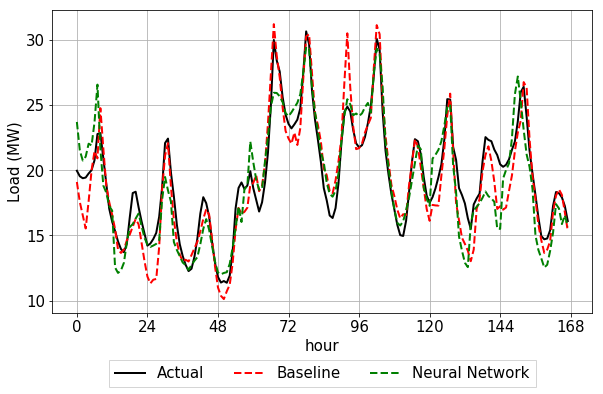

In [121]:
size = 15

plt.clf()
fig, ax = plt.subplots(figsize = (10, 6))
thick = 2
plt.plot(x, obs, linewidth = thick, c = 'k', label = 'Actual')
plt.plot(x, predVal, linewidth=thick, linestyle = '--', c = 'r', label = 'Baseline')
plt.plot(x, NN, linewidth=thick, linestyle = '--', c = 'g', label = 'Neural Network')
plt.xticks([24 * i for i in range(8)], fontsize = 15)
plt.yticks( fontsize = 15)
plt.xlabel('hour', fontsize = size)
plt.ylabel('Load (MW)', fontsize = size)
ax.set_position([0.15, 0.2, 0.75, 0.7])
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow = False, ncol = 3, fontsize = 15)
plt.grid()
#plt.legend()
plt.savefig('plots/predictions.png', bbox_inches='tight')
plt.show()

In [78]:
def predictValue(df):
    wd = df['weekday']
    s  = df['season']
    h  = df['hour']
    z  = df['zone']
    print (s, wd, z, h)
    model = bestModel[s][wd][z][h]
    wIndex = bestWeather[s][wd][z][h]
    T = df['w{}'.format(wIndex)]
    d = df['Unnamed: 0']
    inpt = [1, T, T**2, T*d, T**2*d, d]
    
    return sum(inpt[i] * model.params[i] for i in range(len(inpt)))

In [48]:
title = 'final_prediction_par_'
for zone in range(1, 2):

    input_data = pd.read_csv(path + '/NN_inputs/similar_days_df_z{}.csv'.format(zone))
    input_data['month'] = sum(i * input_data['month_{}'.format(i)] \
            for i in range(1, 13))
    input_data['hour'] = sum(i * input_data['hour_{}'.format(i)] \
            for i in range(24))
    input_data['season'] = input_data.apply(season, axis=1)
    input_data['zone'] = zone
    
    input_data['prediction_param'] = input_data.apply(predictValue, axis=1)
    
    output = input_data[['zone', 'month', 'hour', 'prediction_param']]

    
    output.to_csv(path + '/NN_inputs/{}{}'.format(title, str(zone)))

In [100]:
list(solutions)

['id',
 'zone_id',
 'year',
 'month',
 'day',
 'h1',
 'h2',
 'h3',
 'h4',
 'h5',
 'h6',
 'h7',
 'h8',
 'h9',
 'h10',
 'h11',
 'h12',
 'h13',
 'h14',
 'h15',
 'h16',
 'h17',
 'h18',
 'h19',
 'h20',
 'h21',
 'h22',
 'h23',
 'h24',
 'weight',
 'season']

In [125]:
sols = pd.read_csv(path + '/GEFCOM/Load_solution.csv')
minDate = datetime(2004, 1, 1)
maxDate = datetime(2008, 6, 30)
f =  open(path + '/NN_inputs/finalized_results.csv', 'wt')
writer = csv.writer(f, delimiter = ',')
writer.writerow(['zone', 'Year', 'Month', 'Day', 'Hour', 'actual', 'predicted'])
for i in range(len(sols['id'])):
   
    z = sols['zone_id'][i]
    y = sols['year'][i]
    m = sols['month'][i]
    d = sols['day'][i]
    if int(z) == 21 or datetime(y, m, d) > maxDate: 
        continue
    pred = predict(y, m, d, z)
        
    for h in range(1, 25):
        actual = sols['h{}'.format(h)][i]
        writer.writerow([int(z), y, m, d, h - 1, actual, pred[h - 1]])


In [131]:
main_data = pd.read_csv(path + '/NN_inputs/finalized_results.csv')
outTitle = 'parametric_prediction_z'
for zone, df_zone in main_data.groupby('zone'):
    df_zone.to_csv(path + '/NN_inputs/{}{}.csv'.format(outTitle, zone))

In [126]:
main_data = pd.read_csv(path + '/NN_inputs/finalized_results.csv')

In [129]:
len(main_data['zone']) / 20 / 24 

56.0